In [1]:
! pip install opencv-python
! pip install ftfy regex tqdm
! pip install streamlit
! pip install torchray
! pip install torchvision
! pip install grad-cam

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from model import build_model
from clip_ import load, tokenize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import streamlit as st
from torchray.attribution.grad_cam import grad_cam
from matplotlib import rc
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib

from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam import GuidedBackpropReLUModel


In [3]:
torch.cuda.is_available()

False

In [4]:
def show_cam_on_image(img, mask, neg_saliency=False):
    if neg_saliency:
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_RAINBOW)
    else:
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def show_overlapped_cam(img, neg_mask, pos_mask):
    neg_heatmap = cv2.applyColorMap(np.uint8(255 * neg_mask), cv2.COLORMAP_RAINBOW)
    pos_heatmap = cv2.applyColorMap(np.uint8(255 * pos_mask), cv2.COLORMAP_JET)
    neg_heatmap = np.float32(neg_heatmap) / 255
    pos_heatmap = np.float32(pos_heatmap) / 255
    # try different options: sum, average, ...
    heatmap = neg_heatmap + pos_heatmap
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

In [5]:
class Matcher(torch.nn.Module):
    
    def __init__(self, model_visual, txt_features):
        super().__init__()
        
        self.model_visual = model_visual
        self.txt_features = txt_features
        
    def forward(self, image):
        image_features = self.model_visual(image)
        image_features_norm = image_features.norm(dim=-1, keepdim=True)
        image_features_new = image_features / image_features_norm
        res = torch.zeros((image_features_new.size(0), 2))
        sim = torch.tensordot(image_features_new, self.txt_features, dims=([1],[1]))
        res[:,0] = sim
        res[:,1] = 1-sim  # or maybe -sim 
        return res #img_features.dot(self.txt_features)

def reshape_transform(tensor, height=12, width=12):
    tensor = tensor[0]
    print(tensor.shape)
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [6]:
def interpret_vit(image, text, model, device, neg_saliency=False, index=None):
    
    image_relevance, image = vit_relevance(image, text, model, device, neg_saliency=neg_saliency, index=index)
    vis = show_cam_on_image(image, image_relevance, neg_saliency=neg_saliency)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    
    plt.imshow(vis)

def interpret_vit_overlapped(image, text, model, device, index=None):
    
    pos_image_relevance, _ = vit_relevance(image, text, model, device, neg_saliency=False, index=index)
    neg_image_relevance, image = vit_relevance(image, text, model, device, neg_saliency=True, index=index)

    vis = show_overlapped_cam(image, neg_image_relevance, pos_image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)

In [7]:
def rn_relevance(image, text, model, device, neg_saliency=False, index=None):   
    
    model.visual.eval()
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    similarity = image_features_new[0].dot(text_features_new[0])
 
    sim_model = Matcher(model.visual, text_features_new)
    target_layers = [model.visual.layer4[1].relu]
    
    cam = ScoreCAM(model=sim_model,
                   target_layers=target_layers,
                   use_cuda=torch.cuda.is_available()
                   )
        
 
    grayscale_cam = cam(input_tensor=image,
                        target_category=0)

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    cam_image = show_cam_on_image(image, grayscale_cam)
    return image_relevance, image

In [8]:
def interpret_rn(image, text, model, device, neg_saliency=False, index=None):   
   
    image_relevance, image = rn_relevance(image, text, model, device, neg_saliency=neg_saliency, index=index)
    vis = show_cam_on_image(image, image_relevance, neg_saliency=neg_saliency)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
    
def interpret_rn_overlapped(image, text, model, device, index=None):   
   
    pos_image_relevance, _ = rn_relevance(image, text, model, device, neg_saliency=False, index=index)
    neg_image_relevance, image = rn_relevance(image, text, model, device, neg_saliency=True, index=index)

    vis = show_overlapped_cam(image, neg_image_relevance, pos_image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)

In [9]:
st.sidebar.header('Options')
alpha = st.sidebar.radio("select alpha", [0.5, 0.7, 0.8], index=1)
layer = st.sidebar.selectbox("select saliency layer", ['layer4.2.relu'], index=0)

device = "cuda" if torch.cuda.is_available() else "cpu"

model_rn, preprocess = load("RN50", device=device, jit=False)
model, preprocess = load("ViT-B/32", device=device, jit=False)

2021-12-02 20:46:37.509 
  command:

    streamlit run /home/mamooler/anaconda3/envs/DL/lib/python3.6/site-packages/ipykernel_launcher.py [ARGUMENTS]
/home/mamooler/anaconda3/envs/DL/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [10]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [11]:
def sim_score(model, image, texts):
        texts = tokenize(texts).to(device)
        logits_per_image, logits_per_text = model(image, texts)
        probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

        return probs[0]

In [12]:
root = "../Images/"
img_ids = ["horse&dog.jpg", "horse&sheep.jpg", "cow&sheep.jpg"]#, "vase_or_face.png", "duck-rabbit.jpeg"]

text_lists = [["a horse", "a dog"],
              ["a horse", "a sheep"],
              ["a cow", "a sheep"],
              ]

model_types = ["RN50"]

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])
print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7fa037887510>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [13]:

def vit_relevance(image, text, model, device, neg_saliency=False, index=None):

    model.visual.eval()
    
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    similarity = image_features_new[0].dot(text_features_new[0])
 
    sim_model = Matcher(model.visual, text_features_new)
    target_layers = [list(dict(model.visual.transformer.resblocks.named_children()).values())[-1].attn]
    
    cam = ScoreCAM(model=sim_model,
                   target_layers=target_layers,
                   use_cuda=torch.cuda.is_available(),
                   reshape_transform=reshape_transform)
        
 
    grayscale_cam = cam(input_tensor=image,
                        target_category=0)

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    cam_image = show_cam_on_image(image, grayscale_cam)


a horse


/home/mamooler/anaconda3/envs/DL/lib/python3.6/site-packages/torch/nn/functional.py:1204: UserWarning: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is deprecated and will be forbidden starting version 1.6. You can remove this warning by cloning the output of the custom Function. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554790289/work/torch/csrc/autograd/variable.cpp:547.)
  result = torch.relu_(input)


[tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.2603e-01,
           1.3808e-01, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4111e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2672e-02, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 6.1190e-02]],

         [[0.0000e+00, 0.0000e+00, 4.6940e-02,  ..., 1.4551e-01,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 3.8841e-01, 4.4538e-01,  ..., 2.3293e-01,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 3.2768e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [3.7256e-01, 5.4316e-01, 5.7146e-01,  ..., 8.125

ValueError: need at least one array to concatenate

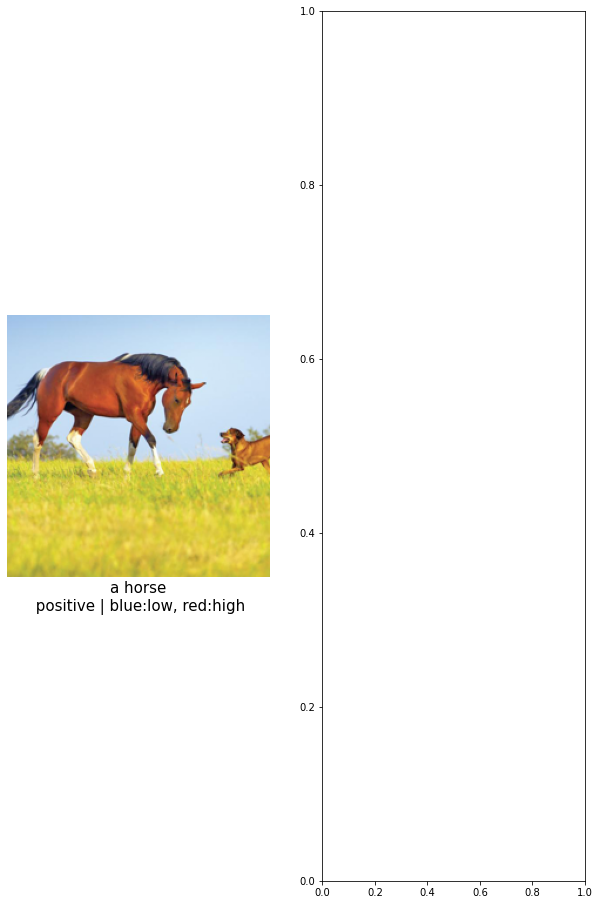

In [14]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['mathtext.size'] = 16

#fig, ax = plt.subplots(len(2*img_ids), 3, figsize=(16,16))

for id_, img_id in enumerate(img_ids):
    texts = text_lists[id_]
    for t_id, text in enumerate(texts):
        print(text)
        t_text = tokenize(text).to(device)
        
        for neg in [False, True]:#, None]:
            
            img_path =  os.path.join(root, img_id )
            image = ori_preprocess(Image.open(img_path))


            plt.figure(figsize=(16, 16))
            plt.tight_layout()
            plt.subplot(131)
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            if neg==None: caption = text+"\n overlapped  | blue:neg, red: pos"
            elif neg==True: caption = text+"\n negative | blue: high, red: low"
            else: caption = text+ "\n positive | blue:low, red:high"
            plt.title(caption, **font, y=-0.15)
        
            p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

            subplot = 132
                
            for model_id, model_type in enumerate(model_types):
           
                plt.subplot(subplot+model_id)
            
                if model_type=="ViT":
                    
                    if not neg==None:
                        vit_relevance(model=model, image=p_image, text=t_text, neg_saliency=neg, device=device, index=0)
                    else:
                        interpret_vit_overlapped(model=model, image=p_image, text=t_text, device=device, index=0)

                else:
                        
                    if not neg==None:
                        rn_relevance(model=model_rn, image=p_image, text=t_text, neg_saliency=neg, device=device, index=0)
                    else:
                        interpret_rn_overlapped(model=model_rn, image=p_image, text=t_text, device=device, index=0)
                            
                

                plt.title(model_type, **font,y=-0.15)
                plt.tight_layout()
                plreshape_transform=reshape_transformt.axis('off')

                # dir_path = f'comparison/img_text/'
                # if not os.path.exists(dir_path):
                #     os.mkdir(dir_path)
                # plt.savefig(f'{dir_path}{model_type}_{img_id}_vs_{t_id}.jpg', bbox_inches='tight')